# 1. Introduktion

**AdventureWorks 2025 försäljningsanalys.**

*Syfte:*

Analysen går ut på att bryta ner försäljning på geografi och tid så att produkter och deras kategorier kan åskådliggöras vad som säljs bäst och även se hur säsonger har inverkan på detta. Med SQL görs datahämtning på ett smidigt sätt som python låts göra visualiseringar på, och detta leder till att rekommendationer till företaget kan göras som berör optimering av regionernas försäljning. Ett mål är att dra lärdomar av hur affärsfrågor förnärmas med SQL och handskas med *caveats* som uppkommer, exempelvis hur första och sista året endast håller halva år med orderdata så de bör inte räknas som hela år, varvid implikationer och bemötande åtgärder följer.

# 2. Setup

## 2.1 Imports

Som i requirements.txt används följande python paket:

pandas, numpy, matplotlib, seaborn, sqlalchemy, pyodbc.

In [1]:
import pandas as pd, numpy as np, pyodbc
import matplotlib.pyplot as plt
from sqlalchemy import create_engine, text
from urllib.parse import quote_plus

## 2.2. Python och SQL: drivrutiner, connection och funktion

In [2]:
pyodbc.drivers()

['SQL Server',
 'ODBC Driver 18 for SQL Server',
 'Microsoft Access Driver (*.mdb, *.accdb)',
 'Microsoft Excel Driver (*.xls, *.xlsx, *.xlsm, *.xlsb)',
 'Microsoft Access Text Driver (*.txt, *.csv)',
 'Microsoft Access dBASE Driver (*.dbf, *.ndx, *.mdx)']

In [3]:
# quote_plus motverkar UTF-8 issues i connection.

user = "SA"
password = quote_plus(input(""))
server = "localhost:1433"
database = "AdventureWorks2025"
driver = quote_plus("ODBC Driver 18 for SQL Server")

connection_string = (
    f"mssql+pyodbc://{user}:{password}@{server}/{database}"
    f"?driver={driver}&Encrypt=yes&TrustServerCertificate=yes"
)

engine = create_engine(connection_string)

In [4]:
def query_df(sql: str):
    with engine.connect() as conn:
        return pd.read_sql(text(sql), conn)

# 3. Visualiseringar

## 3.1 Antal produkter per kategori

Hur många produkter finns i varje kategori?

* *Metod:* 

SQL query körs via en funktion i python som hämtar kolumner och rader från databasen, vilka sparas som en pandas dataframe. Matplotlib går utifrån insparad dataframe.

Eftersom Person.Person.ProductID är en primär nyckel med inkrement, behövs inte DISTINCT inom COUNT(Production.Product.ProductID). COUNT-beräkningen är en aggregerad funktion som är möjliggjord via GROUP BY utav kategorinamnen. Alltså räknar count alla närvarande produkt-id i queryn och visar hur många produkter som finns per kategori.

Tack vare LEFT JOIN, med Production.Product tabellen på vänster sida, räknar query 1 rader (produkter) som saknar ProductSubcategoryID såväl som produkter som är kategoriserade. En INNER JOIN skulle missat okategoriserade rader, som ändå python kan ta bort igen med slicing om man vill veta högsta och lägsta presteraren.

C:\Users\marti\AppData\Local\Temp\ipykernel_21068\4012941776.py:2: SAWarning: Unrecognized server version info '17.0.1000.7'.  Some SQL Server features may not function properly.
  with engine.connect() as conn:


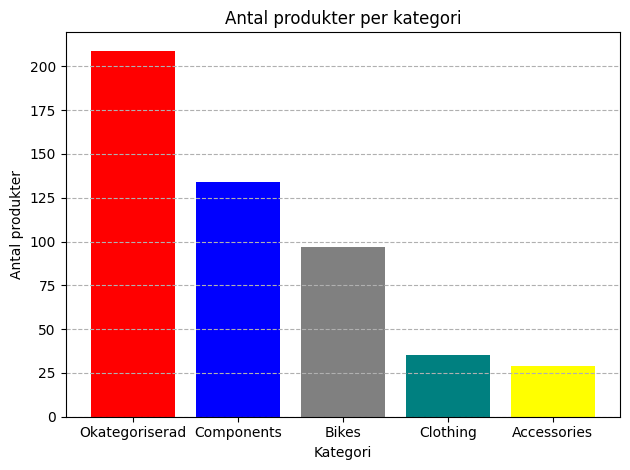


Kategori med flest produkter:
Kategori          Components
AntalProdukter           134
dtype: object

Kategori med minst produkter:
Kategori          Accessories
AntalProdukter             29
dtype: object


In [5]:
query_1 = """
SELECT ISNULL(ppc.Name, 'Okategoriserad') AS Kategori, 
            COUNT(pp.ProductID) AS AntalProdukter 
FROM Production.Product AS pp 
LEFT JOIN Production.ProductSubcategory AS pps 
    ON pp.ProductSubcategoryID = pps.ProductSubcategoryID 
LEFT JOIN Production.ProductCategory AS ppc 
    ON pps.ProductCategoryID = ppc.ProductCategoryID 
GROUP BY ppc.Name ORDER BY AntalProdukter DESC;"""

query_1_df = query_df(query_1) 
# display(query_1_df)

colors = ['red', 'blue', 'grey', 'teal', 'yellow']
plt.bar(query_1_df.Kategori, query_1_df['AntalProdukter'], color=colors) 
plt.title('Antal produkter per kategori') 
plt.xlabel('Kategori') 
plt.ylabel('Antal produkter') 
plt.grid(True, axis='y', linestyle='--') 
plt.tight_layout() 
plt.show()

# Sortera ut okategoriserade produkter med slicing:
query_1_df_mod = query_1_df.iloc[1:,:] 

# Printa flest & minst produkter
print('\nKategori med flest produkter:') 
print(query_1_df_mod.max())
print('\nKategori med minst produkter:') 
print(query_1_df_mod.min()) 

Ovan är en stapelgraf som visar olika stora produktkategorier utefter deras försäljning, följt av en specifikation av kategorier med flest och minst produkter.

Det går att lära sig mer detaljerade insikter, till exempel genom att inspektera okategoriserade produkter med en LEFT JOIN & WHERE IS NULL query, för då kan man t.ex. åtgärda att kategorisering saknas för vissa produkter med SQL's INSERT INTO VALUES. Givet, somliga produkter kanske inte ska lanseras. Queryn nedan tar fram okategoriserade produkter. En efterföljande query ger insikt i hur många produkter som slutat säljas.

In [6]:
query_1_bonus = """ 
SELECT pp.ProductID AS ProduktID, 
            pp.Name AS ProduktNamn, 
            pp.ProductSubcategoryID AS SubkategoriID, 
            pps.Name AS SubkategoriNamn, 
            ppc.Name AS KategoriNamn 
FROM Production.Product AS pp 
LEFT JOIN Production.ProductSubcategory AS pps 
    ON pp.ProductSubcategoryID = pps.ProductSubcategoryID 
LEFT JOIN Production.ProductCategory AS ppc 
    ON pps.ProductCategoryID = ppc.ProductCategoryID 
WHERE pp.ProductSubcategoryID IS NULL 
ORDER BY pp.ProductID;"""

query_1_bonus_df = query_df(query_1_bonus) 
query_1_bonus_df.tail(3)   # titta på sista 3 raderna

,ProduktID,ProduktNamn,SubkategoriID,SubkategoriNamn,KategoriNamn
206,534,Top Tube,None,None,None
207,535,Tension Pulley,None,None,None
208,679,Rear Derailleur Cage,None,None,None


Längden på resulterande tabell stämmer mot grafens stapel Okategoriserad.

Vidare insikter kan komma ifrån att granska frekvens av kategorier med aktiva och utgångna produkter.

In [7]:
query_1_active = """ 
SELECT ISNULL(ppc.Name, 'Okategoriserad') AS Kategori, 
        COUNT(pp.ProductID) AS AntalProdukter 
FROM Production.Product AS pp 
LEFT JOIN Production.ProductSubcategory AS pps 
    ON pp.ProductSubcategoryID = pps.ProductSubcategoryID 
LEFT JOIN Production.ProductCategory AS ppc 
    ON pps.ProductCategoryID = ppc.ProductCategoryID 
WHERE pp.SellEndDate IS NULL GROUP BY ppc.Name 
ORDER BY AntalProdukter DESC; """

query_1_active_df = query_df(query_1_active) 
diff = query_1_df.AntalProdukter - query_1_active_df.AntalProdukter 
query_1_active_copy = query_1_active_df.copy() 
query_1_active_copy['Differens'] = diff 
query_1_active_copy['HistoriskaOchAktivaProdukter'] = query_1_df.AntalProdukter 
query_1_active_copy

,Kategori,AntalProdukter,Differens,HistoriskaOchAktivaProdukter
0,Okategoriserad,209,0,209
1,Components,95,39,134
2,Bikes,60,37,97
3,Accessories,22,13,35
4,Clothing,20,9,29


I resulterande tabell med tillagd kolumn Differens via python-kod (visar antalet inaktiva produkter), som givetvis skulle gå att ta fram via SQL query också, ser vi att inaktiva produkter inom Components är 39st, och så vidare. Alltså är potentiellt LEFT JOIN + WHERE pp.SellEndDate IS NULL ett välbehövligt filter för query 1 ifall inaktiva produkter ska borträknas i kategoriuppdelningen.

## 3.2 Försäljning per produktkategori

Vilka produktkategorier genererar mest intäkter?

* *Metod:* 

SQL's INNER JOIN som fångar upp sålda produkter sammanfogar Product, ProductSubcategory och SalesOrderDetail-tabellerna, vi grupperar efter kategori och summerar omkostnaden (kolumn LineTotal). Då erhålles en dataframe som går att göra plots på. Vi gör en förfinad tabell beaktandes kategoriserade produkter (mer utvecklad query än förstkommande), som även beräknar värden för nuvarande aktiva produkter och differens mot inklusive inaktiva produkters försäljning, alltså inräknad historik. 

In [8]:
query_2 = """ 
SELECT ppc.Name AS Kategori, 
        SUM(ssod.LineTotal) AS TotalFörsäljning 
FROM Production.ProductCategory AS ppc 
INNER JOIN Production.ProductSubcategory AS pps 
    ON ppc.ProductCategoryID = pps.ProductCategoryID 
INNER JOIN Production.Product AS pp 
    ON pps.ProductSubcategoryID = pp.ProductSubcategoryID 
INNER JOIN Sales.SalesOrderDetail AS ssod 
    ON pp.ProductID = ssod.ProductID 
GROUP BY ppc.Name 
ORDER BY TotalFörsäljning DESC; """
query_2_df = query_df(query_2) 
# query_2_df


# Mer utvecklad version
query_2_active = """ 
SELECT ppc.Name AS Kategori, 
        SUM(ssod.LineTotal) AS TotalFörsäljning 
FROM Production.ProductCategory AS ppc 
INNER JOIN Production.ProductSubcategory AS pps 
    ON ppc.ProductCategoryID = pps.ProductCategoryID 
INNER JOIN Production.Product AS pp 
    ON pps.ProductSubcategoryID = pp.ProductSubcategoryID 
INNER JOIN Sales.SalesOrderDetail AS ssod 
    ON pp.ProductID = ssod.ProductID 
WHERE pp.SellEndDate IS NULL 
GROUP BY ppc.Name
ORDER BY TotalFörsäljning DESC;"""

query_2_active_df = query_df(query_2_active)
diff = query_2_df.TotalFörsäljning - query_2_active_df.TotalFörsäljning 
query_2_active_copy = query_2_active_df.copy() 
query_2_active_copy['Differens'] = diff.round(0).astype(int) 
query_2_active_copy['HistoriskFörsäljning'] = query_2_df.TotalFörsäljning.round(0).astype(int) 
query_2_active_copy['TotalFörsäljning'] = query_2_active_copy['TotalFörsäljning'].round(0).astype(int)

print("Här är en presentationsvänlig tabell på försäljning per kategori:") 
display(query_2_active_copy) 
print("Differens beskriver storleken på försäljning på produkter som slutat säljas.")

Här är en presentationsvänlig tabell på försäljning per kategori:


,Kategori,TotalFörsäljning,Differens,HistoriskFörsäljning
0,Bikes,61069197,33581976,94651173
1,Components,9468393,2334200,11802593
2,Clothing,1531721,588821,2120543
3,Accessories,1242318,29755,1272073


Differens beskriver storleken på försäljning på produkter som slutat säljas.


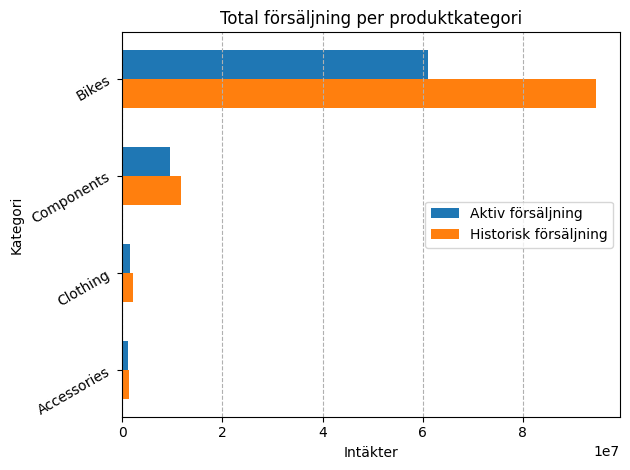

Högst försäljning: 94651172.704731,
Och för aktiva produkter: 61069196.787288
-----------------------------------------
Lägst försäljning: 1272072.883926,
Och för aktiva produkter: 1242317.97665


In [9]:
cols = ['TotalFörsäljning','HistoriskFörsäljning'] # behöver sortera som stigande, för barh plot ska ha högst överst.
ascending_df = query_2_active_copy.copy().sort_values(by=cols, ascending=True) # använder den förfinade tabellen
categories = ascending_df['Kategori'] # plockar ut kolumner som ska plottas till variabler
active_sales = ascending_df['TotalFörsäljning']
historic_sales = ascending_df['HistoriskFörsäljning']
length = len(ascending_df) # hur många staplar ska plottas
y = np.arange(length) 
width = 0.3

plt.figure()
plt.barh(y + width/2, active_sales, width, label='Aktiv försäljning')
plt.barh(y - width/2, historic_sales, width, label='Historisk försäljning')

plt.yticks(y, categories, rotation=30)
plt.ylabel('Kategori')
plt.xlabel('Intäkter')
plt.title("Total försäljning per produktkategori")
plt.legend(loc='center right')
plt.grid(True, axis='x', linestyle="--")
plt.tight_layout()
plt.show()

print(f"""Högst försäljning: {query_2_df.TotalFörsäljning[0]},
Och för aktiva produkter: {query_2_active_df.TotalFörsäljning[0]}""")
print("-----------------------------------------")
print(f"""Lägst försäljning: {query_2_df.TotalFörsäljning[len(query_2_df)-1]},
Och för aktiva produkter: {query_2_active_df.TotalFörsäljning[len(query_2_active_df)-1]}""") 
# len() för att ta sista indexplatsen, alltså lägsta siffran.

Visualiseringen visar beaktar historiska totala-, och aktiva produkters totala försäljning, följt av en specifikation av exakta siffrorna för högst respektive lägst försäljning, som tillfaller kategorin cyklar och accessoarer (oavsett aktivitetsfiltret).

Det går att lära sig flera saker här.

* Avvecklade produkter tjänar inte längre pengar, nämligen är aktiva produkter vad företaget måste arbeta med, uppdatera produkter ifall en leverantör slutar tillverka en särskild cykel, som exempel.

* Kategorier med högst intäkter är beroende av produkternas kvantiteter sålda och deras priser, och där är vinstmarginal och kostnadsstruktur viktig för sådan analys. Cyklar är dyra vilket driver på den figuren som är högst.

* Fråga 2 berör intäkter, och inte ens över tid, vilket två följande delkapitel handlar om. Geografiska intäkter gås igenom i **3.7**.

* Exempelvis validering av data kan göras med LEFT JOIN query för att se okategoriserade produkter som har sett försäljning, för att inte missa intäkter i våra beräkningar.
    * Resten av detta delkapitel behandlar denna valideringsfråga.

In [10]:
query_2_left = """ 
SELECT pp.ProductID AS ProduktID, 
        pp.Name AS ProduktNamn, 
        pps.Name AS SubkategoriNamn, 
        ppc.Name AS KategoriNamn, 
        SUM(ssod.LineTotal) AS TotalFörsäljning 
FROM Production.Product AS pp 
LEFT JOIN Production.ProductSubcategory AS pps 
    ON pp.ProductSubcategoryID = pps.ProductSubcategoryID 
LEFT JOIN Production.ProductCategory AS ppc 
    ON pps.ProductCategoryID = ppc.ProductCategoryID 
LEFT JOIN Sales.SalesOrderDetail AS ssod 
    ON pp.ProductID = ssod.ProductID 
GROUP BY ppc.Name, pps.Name, pp.Name, pp.ProductID 
ORDER BY TotalFörsäljning DESC; """

query_2_left_df = query_df(query_2_left) 
display(query_2_left_df.tail(3)) # titta på sista 3 raderna

,ProduktID,ProduktNamn,SubkategoriNamn,KategoriNamn,TotalFörsäljning
501,679,Rear Derailleur Cage,None,None,NaN
502,680,"HL Road Frame - Black, 58",Road Frames,Components,NaN
503,706,"HL Road Frame - Red, 58",Road Frames,Components,NaN


In [11]:
# python overview av query_2_left_df
print("Här är hur många rader som saknar kategori men ändå haft försäljning: ", len(
    query_2_left_df[(query_2_left_df['KategoriNamn'].isna()) & 
                    (query_2_left_df['TotalFörsäljning'] > 0)])) # blir noll 

Här är hur många rader som saknar kategori men ändå haft försäljning:  0


Validering av okategoriserade produkter som sett försäljning:

Eftersom alla okategoriserade produkter har NaN i TotalFörsäljning, är slutsatsen att INNER JOIN räcker för intäktsanalysen. Okategoriserade produkter kan härstamma som prototyper, icke-lanserade, reservdelar eller produkter som används inuti företaget.

## 3.3 Försäljningstrend över tid

Hur har försäljningen utvecklats över tid?

* *Metod:* 

Inga JOINs är aktuella, då vi har datum och siffror såsom totalkostnad inklusive moms per order i denna tabellen. Vi specificerar SELECT med önskade kolumner och kollar efter NaN, som visades saknas. Query_3 kommenteras ut, och query_3_agg räknar ihop ordervärden per månad, vilket plottas tillsammans med rullande medelvärde på 3 månader. X-axelns visade värden får presenteras uppdelat, och med lite rotation. Vi håller oss till analys som bortser från frakt, skatt och omkostnad exklusive moms. Förvisso kan det aggregeras siffror för sådana mätvärden över tidsperioden, medan analysen blir tillräcklig utan att gå in på de detaljerna.

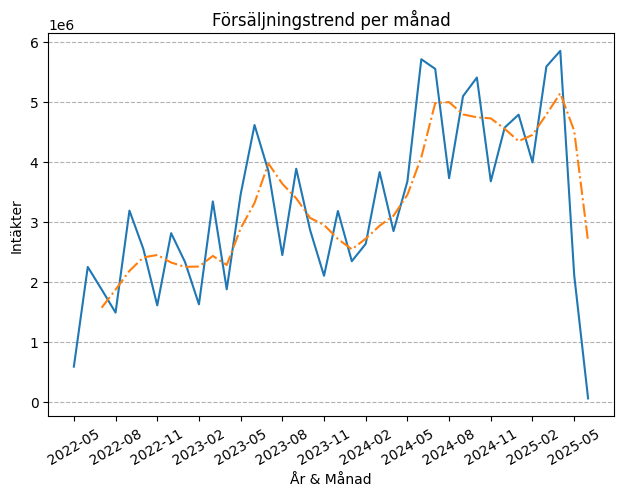


---------------------------------------------------------------------------
Högsta försäljningssiffran och aktuell månad: 5847164.7, 2025-04

Lägsta försäljningssiffran och aktuell månad: 52478.2, 2025-06



In [12]:
query_3 = """
SELECT OrderDate,
        TotalDue
FROM Sales.SalesOrderHeader
"""
query_3_df = query_df(query_3)
# display(query_3_df.tail(4))
# display(query_3_df.info()) # inga rader är NaN.

# kika på tidigaste och senaste datum. 
# print(query_3_df.OrderDate.min()) # 2022-05-30 är första datum.
# print(query_3_df.OrderDate.max()) # 2025-06-29 är sista datum.
# Ordrarna är i stigande ordning.


query_3_agg = """
SELECT FORMAT(OrderDate, 'yyyy-MM') AS Månad,
        SUM(TotalDue) TotalFörsäljning
FROM Sales.SalesOrderHeader
GROUP BY FORMAT(OrderDate, 'yyyy-MM')
ORDER BY Månad"""

query_3_agg_df = query_df(query_3_agg)
# query_3_agg_df.tail(4) # visar sista 4 månaderna


plt.figure()
plt.plot(query_3_agg_df.Månad, query_3_agg_df.TotalFörsäljning)
plt.title("Försäljningstrend per månad")
plt.xlabel("År & Månad")
plt.ylabel("Intäkter")
plt.tight_layout()
plt.grid(True, axis='y', linestyle="--")
plt.xticks(query_3_agg_df.Månad[::3], rotation=30)
plt.plot(query_3_agg_df.Månad, query_3_agg_df.TotalFörsäljning.rolling(3).mean(), label="Glidande medelvärde",
         linestyle="-.")
plt.show()

print("\n---------------------------------------------------------------------------")
max_sales = query_3_agg_df.loc[query_3_agg_df.TotalFörsäljning.idxmax()]
min_sales = query_3_agg_df.loc[query_3_agg_df.TotalFörsäljning.idxmin()]
print(f"Högsta försäljningssiffran och aktuell månad: {max_sales.TotalFörsäljning.round(1)}, {max_sales.Månad}\n")
print(f"Lägsta försäljningssiffran och aktuell månad: {min_sales.TotalFörsäljning.round(1)}, {min_sales.Månad}\n")

Ovan är en graf med månadsvis aggregering av försäljningssiffrorna, inklusive historiska och aktiva produkter.

Ett glidande medelvärde med 3 månader lagg låter oss se trendutvecklingen, som annars också skulle kunna fås fram genom att aggregera flera månader till samma datapunkt med medelvärden av intäkterna.

En strikt linje från början av grafen, till slutet (innan det dramatiska fallet som påbörjas efter maximum vid 2025-04) skulle visa en stadigt stigande trend. Detta görs med linjär regression, dock inte i denna studie.

De två andra vassa topparna, förutom den sista längst till höger, skedde under månad 5 och 6 under de åren, så visst säsongsmönster finns fastän de flesta dalar är lite oregelbundna (inte jämnt ökande med intäkter).

Att den månadsvisa aggeregerade grafen är volatil öppnar ändå för frågan om försäljningssiffrorna är säsongsberoende, som är knepigt att direkt läsa av månadsvisa försäljningsgrafen ovan. Om statistiska mått involveras såsom medelvärde, median, och procentskillnader går det att nå fram till uppskatning av vilken grad siffrorna är säsongsbundna, och om tillväxten är linjär blir säsongernas mönster enklare att bedöma.

Det går vidare att lära sig om säsongsberoende mönster, exempelvis genom att se hur månader, 3 emellan, ser ut på egna grafer, vilket testas nedan.

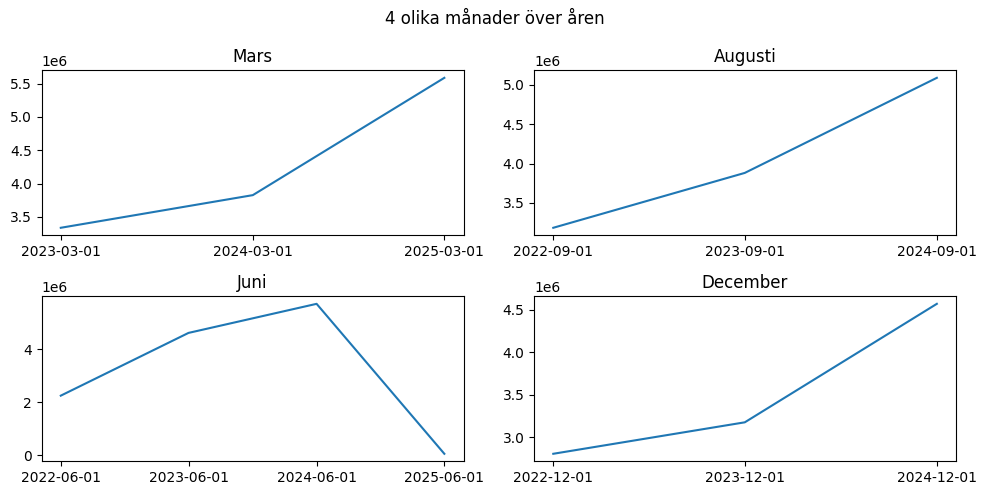

In [13]:
query_3_agg_df.Månad = pd.to_datetime(query_3_agg_df.Månad)
query_3_agg_df['MånadNummer'] = query_3_agg_df.Månad.dt.month

mars = query_3_agg_df[query_3_agg_df.MånadNummer == 3 ] # här kan man lägga till -1, eller -2, så ser man andra månader.
juni = query_3_agg_df[query_3_agg_df.MånadNummer == 6 ]
aug = query_3_agg_df[query_3_agg_df.MånadNummer ==  9 ]
dec = query_3_agg_df[query_3_agg_df.MånadNummer ==  12]

fig, axes = plt.subplots(2,2, figsize=(10,5))
plt.suptitle("4 olika månader över åren")
axes[0,0].plot(mars.Månad, mars.TotalFörsäljning)
axes[0,0].set_xticks(mars.Månad)
axes[0,0].set_title("Mars")

axes[1,0].plot(juni.Månad, juni.TotalFörsäljning)
axes[1,0].set_xticks(juni.Månad)
axes[1,0].set_title("Juni")

axes[0,1].plot(aug.Månad, aug.TotalFörsäljning)
axes[0,1].set_xticks(aug.Månad)
axes[0,1].set_title("Augusti")

axes[1,1].plot(dec.Månad, dec.TotalFörsäljning)
axes[1,1].set_xticks(dec.Månad)
axes[1,1].set_title("December")
plt.tight_layout()

Med kodcellen ovan kan man testa årets 12 månader, 3 månader emellan i graferna. Det finns 3, ibland 4, år med historisk data för månaderna, som kanske inte räcker för att säkerställa att försäljningen är säsongsbunden. Till detta så noteras även att ingen månad hade konsekvent förhöjda intäkter återkommande, vilket dock kan otydliggöras med vetskapen att intäkterna har ökat från start till nästan slutet på datasetet. Andra aggregeringar, såsom ifall två till fyra månader skulle slås samman, skulle kanske visuellt samband kunna framstå. 

## 3.4 Försäljning och antal ordrar per år

Hur ser total försäljning och antal ordrar ut per år?

* *Metod:* 

I början grupperar vi försäljning och ordrar efter år, och inser att första och sista halvåren räknas till egna helår. Denna kod kommenteras ut och följs upp med linjegraf med anpassning till helår förgågna i datasetet (att ett år har gått 2023-05-30). Anpassat dataset på detta vis sammanfaller bättre med en månadsvis linjegraf, som är den sista presenterade visualiseringen i detta delkapitel. Efter första grafen visas försäljning (på det anpassade sättet) med vertikal grupperad stapelgraf, år för år gällande försäljning och antal ordrar. Även följer bästa och sämst presterande åren presenterade numeriskt med stapelgrafen. Efter den är en linjegraf som visar ordrar och försäljning per månad, för att se trendutveckling.

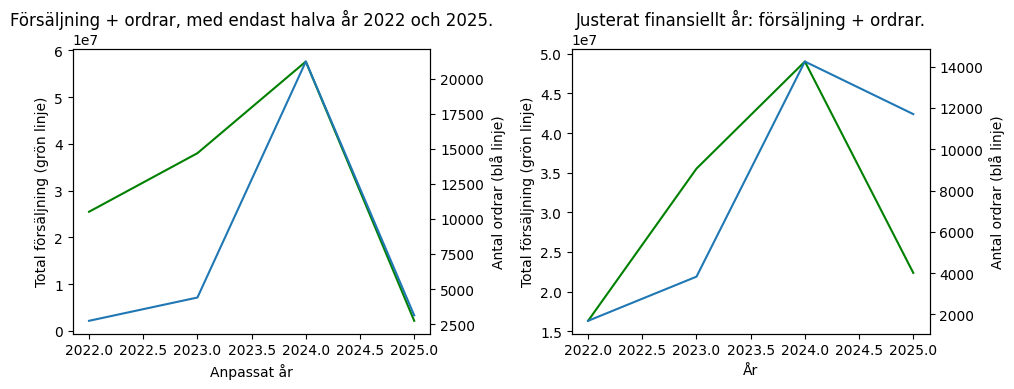

In [14]:
q4 = """
SELECT YEAR(OrderDate) AS År,
        CAST(ROUND(SUM(TotalDue),0) AS INT) TotalFörsäljning,
        COUNT(*) AS AntalOrdrar
FROM Sales.SalesOrderHeader
GROUP BY YEAR(OrderDate)
ORDER BY År"""

q4_df = query_df(q4)
# q4_df plottas till vänster i följande subplot.


# Återkalla tidigare query_3_agg, som ger 38st månader med data.
# lägger till AntalOrdrar.
query_3_agg = """
SELECT FORMAT(OrderDate, 'yyyy-MM') AS Månad,
        SUM(TotalDue) TotalFörsäljning,
        COUNT(*) AS AntalOrdrar
FROM Sales.SalesOrderHeader
GROUP BY FORMAT(OrderDate, 'yyyy-MM')
ORDER BY Månad"""

query_3_agg_df = query_df(query_3_agg)
query_3_agg_df.Månad = pd.to_datetime(query_3_agg_df.Månad)
query_3_agg_df['MånadNummer'] = query_3_agg_df.Månad.dt.month
# query_3_agg_df.head(2)

# Python kan gruppera query_3_agg med ordrar, över anpassade helår.
query_3_agg_df['AnpassatÅr'] = query_3_agg_df['Månad'].apply(lambda x: x.year if x.month >= 5 else x.year - 1)
adapt_year_df = (query_3_agg_df.groupby('AnpassatÅr')[['TotalFörsäljning', 'AntalOrdrar']].sum().reset_index())
# adapt_year_df

# Med troligen samma resultat kan SQL query med CASE ge oss:
q4_agg = """
SELECT
    CASE
        WHEN MONTH(OrderDate) >= 5 THEN YEAR(OrderDate)
        ELSE YEAR(OrderDate) - 1
    END AS AnpassatÅr,
    SUM(TotalDue) AS TotalFörsäljning,
    COUNT(*) AS AntalOrdrar
FROM Sales.SalesOrderHeader
GROUP BY 
    CASE 
        WHEN MONTH(OrderDate) >= 5 THEN YEAR(OrderDate)
        ELSE YEAR(OrderDate) - 1
    END
ORDER BY AnpassatÅr"""
q4_agg_df = query_df(q4_agg)
# q4_agg_df
# Tabellerna ovan stämde överens, så både python och sql kan framkalla anpassad data.

fig, ax = plt.subplots(1,2, figsize=(10,4))

ax[0].plot(adapt_year_df['AnpassatÅr'], adapt_year_df['TotalFörsäljning'], color='green')
ax[0].set_xlabel('Anpassat år')
ax[0].set_ylabel('Total försäljning (grön linje)')
ax[0].set_title('Försäljning + ordrar, med endast halva år 2022 och 2025.')
ax0_2 = ax[0].twinx()
ax0_2.plot(adapt_year_df['AnpassatÅr'], adapt_year_df['AntalOrdrar'])
ax0_2.set_ylabel('Antal ordrar (blå linje)')

ax[1].plot(q4_df.År, q4_df.TotalFörsäljning, color="green")
ax[1].set_xlabel("År")
ax[1].set_ylabel("Total försäljning (grön linje)")
ax[1].set_title('Justerat finansiellt år: försäljning + ordrar.')
ax1_2 = ax[1].twinx() # sekundär y-axel, då ordrar är i tiotusen och försäljning på tiotals miljoner.
ax1_2.plot(q4_df.År, q4_df.AntalOrdrar)
ax1_2.set_ylabel("Antal ordrar (blå linje)")

plt.tight_layout()
plt.show()

Ovan är en sammanställning av årens försäljning (grön linje) och antal ordrar (blå linje), notera att första och sista året är endast halvår med försäljning. För att simulera kompletta försäljningsår skulle det kanske gå att dubblera värdena på första och sista raden. Alternativt skulle beräkningar gå att göra såsom att låta juni 2022 till juni 2023 räknas som första året, och så vidare. 

Anpassat finansiellt år har siffrorna vara stadigt stigande på det sättet, fast försäljningen sjunker skarpare än ordrarna på slutet. Jämfört med vänster graf faller kurvorna ordrar och försäljning mycket mer i tandem i höger graf, en effekt som kommer från hur finansiella åren är inarbetade i analysen. Det bekräftas att hur man mäter helår påverkar visualiseringar. Dessa anmärkningar är bra att känna till för att kunna analysera datasetet korrekt.

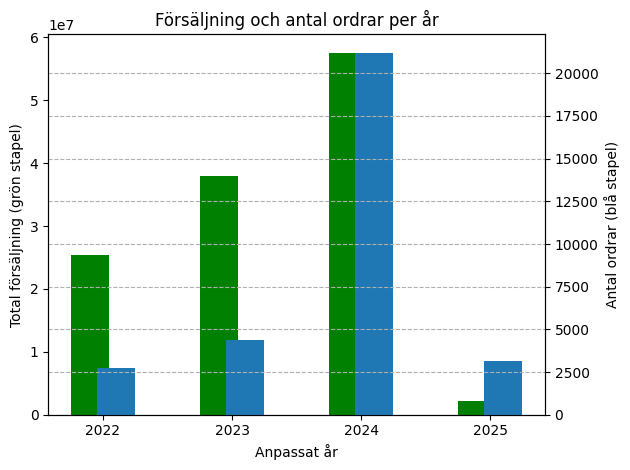

-------------------------------------
Högst försäljning: 57587486, år 2024
-------------------------------------
Lägst försäljning: 2160884, år 2025
-------------------------------------
Flest ordrar: 21213, år 2024
----------------------------
Lägst ordrar: 2735, år 2022


In [15]:
x = np.arange(len(adapt_year_df))

fig, ax = plt.subplots()
ax.bar(x - width/3, adapt_year_df['TotalFörsäljning'], width=0.3, color='green')
ax.set_xlabel('Anpassat år')
ax.set_ylabel('Total försäljning (grön stapel)')

ax2 = ax.twinx()
ax2.bar(x + width/3, adapt_year_df['AntalOrdrar'], width=0.3)
ax2.set_ylabel('Antal ordrar (blå stapel)')

ax.set_xticks(x)
ax.set_xticklabels(adapt_year_df['AnpassatÅr'])
plt.title('Försäljning och antal ordrar per år')
plt.tight_layout()
plt.grid(True, axis='y', linestyle='--')
plt.show()

# Winners & Losers..
max_sales = q4_agg_df.loc[q4_agg_df.TotalFörsäljning.idxmax()]
min_sales = q4_agg_df.loc[q4_agg_df.TotalFörsäljning.idxmin()]
max_orders = q4_agg_df.loc[q4_agg_df.AntalOrdrar.idxmax()]
min_orders = q4_agg_df.loc[q4_agg_df.AntalOrdrar.idxmin()]

print("-------------------------------------")
print(f"""Högst försäljning: {max_sales.TotalFörsäljning.round(0).astype(int)}, år {max_sales.AnpassatÅr.astype(int)}""")
print("-------------------------------------")
print(f"""Lägst försäljning: {min_sales.TotalFörsäljning.round(0).astype(int)}, år {min_sales.AnpassatÅr.astype(int)}""")
print("-------------------------------------")
print(f"""Flest ordrar: {max_orders.AntalOrdrar.astype(int)}, år {max_orders.AnpassatÅr.astype(int)}""")
print("----------------------------")
print(f"""Lägst ordrar: {min_orders.AntalOrdrar.astype(int)}, år {min_orders.AnpassatÅr.astype(int)}""")

Ovan visar, givet 2025 är ett nyligen påbörjat år, att lägst försäljning sker på det ofulländade anpassade året. Lägst ordrar tillfaller första hela året så det mätvärdet har ökat via anpassningen. Försäljning- och ordertrenden är beroende på hur 2025 fortsätter så kan vi se om tillväxten är hållbar eller om nedsaktandet mot slutet av perioden håller i sig. Med dessa få årtal att döma ifrån, är det ändå en positiv stark uppåttrend inledningsvis.

Det som går att läras ifrån denna analys är att vid jämförelse utav en linjegraf av försäljningsdata med anpassad aggregering och en icke-anpassad tabell med 2st halvår (första och sista raderna), kanske framhäver tydligare trender för att komplettera trendmönster-diskussionen i *uppgift 3* som testade mars + juni + okt + dec, och visualisera effekten av halvårs-räknade finansiella år. Med flera visualiseringar kan flera utsagor göras, och mönster som döljer sig för den ena kanske visas i den andra. 

Ytterligare en insikt att databaskännedom kan involvera *caveats* som är bra att känna till för att kunna analysera datasetet korrekt. 

En sista insikt från månadsvisa linjegrafen som följer är att försäljning var rätt spikigt och orderantalen rätt stabila första grafhalvan till vänster, medan de rör sig mera i tandem andra halvan. Sådana här dynamiker syntes inte till i årsgrupperad tabell.

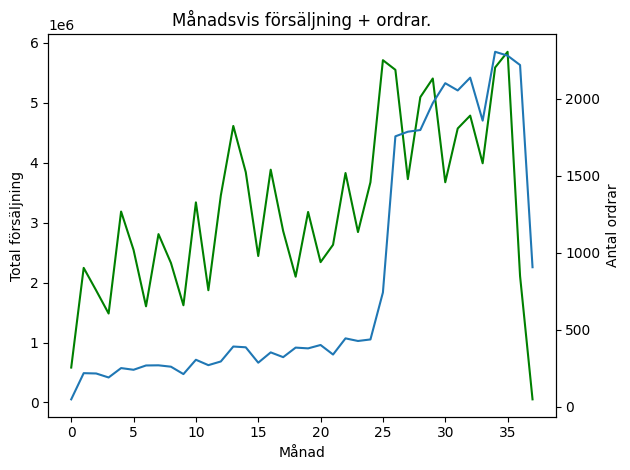

In [16]:
# Här är samma linjegraf som i uppgift 3, men med ordrar per månad inlagda.
x = range(len(query_3_agg_df)) # fixa månadnummer på x axeln

fig, ax = plt.subplots()
ax.plot(x, query_3_agg_df['TotalFörsäljning'], color='green')
ax.set_xlabel('Månad')
ax.set_ylabel('Total försäljning')

ax2 = ax.twinx() # sekundär y-axel
ax2.plot(x, query_3_agg_df['AntalOrdrar'])
ax2.set_ylabel('Antal ordrar')

plt.title('Månadsvis försäljning + ordrar.')
plt.tight_layout()

Som nämnt ovan att orderantal och spikig försäljning inte ser ut att vara helt knutna till varandra genom hela grafen. Med andra ord, i månadsvisa linjegrafen syns till vänster att antal ordrar inte behöver driva försäljningskurvan, samtidigt som på våren 2024 ökar ordrar och försäljning och även slutet av datasettet faller både försäljning och antalet ordrar. Detta tillhör inte helårs-analysen av denna uppgiften men skiner ändå ljus på intressant dynamik.

## 3.5 Top 10 produkter

Vilka 10 produkter genererar mest försäljning?

* *Metod:* 

Först ger jag slutlig query och visualisering, följt av kommentar. Därefter ges stegvisa approachen i kodceller. Det ingick stringmanipulering i SELECT för att få separerat produkterna så de kan grupperas. Nämligen fanns flera storlekar, och även färger, som jag inte grupperat ihop fastän det är ett rimligt förfarande. Det är lite tekniskt dock, på så vis att hur produktnamnen är skrivna och de SQL string funktioner som finns till hands, dock går det att lösa med SQL eller python till exempel med CASE.

Produkt             Mountain-200 Black
SubKategori             Mountain Bikes
TotalFörsäljning       11719760.779149
Name: 0, dtype: object


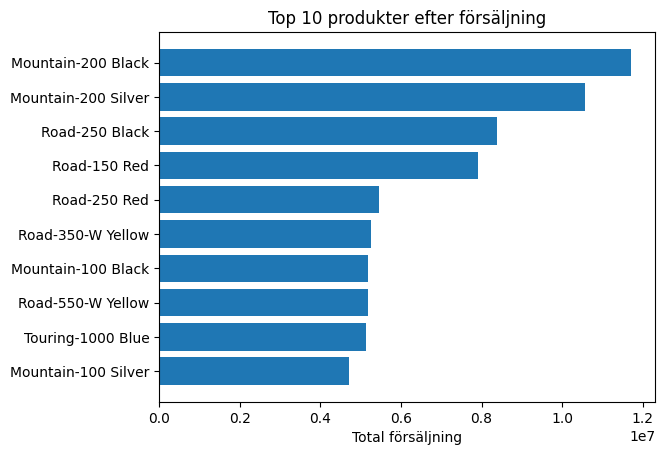

In [17]:
q5_string = """
SELECT TOP 10
    LEFT(pp.Name, CHARINDEX(',', pp.Name)-1) AS Produkt,
    pps.Name AS SubKategori,
    SUM(ssod.LineTotal) AS TotalFörsäljning
FROM Production.Product pp
INNER JOIN Sales.SalesOrderDetail ssod
    ON pp.ProductID = ssod.ProductID
INNER JOIN Production.ProductSubcategory pps
    ON pp.ProductSubcategoryID = pps.ProductSubcategoryID
WHERE CHARINDEX(',', pp.Name) > 0
GROUP BY LEFT(pp.Name, CHARINDEX(',', pp.Name) - 1), pps.Name
ORDER BY TotalFörsäljning DESC;"""
q5_string_df = query_df(q5_string)
# display(q5_string_df)

# Topp produkten och exakt försäljningssiffra, alla storlekar på produkten ihopräknade:
print(q5_string_df.iloc[0])

# Som uppgift 4 behöver vi sortera som stigande för barh plot ska ha högst överst.
ascending_df = q5_string_df.copy().sort_values('TotalFörsäljning', ascending=True)

plt.figure()
plt.barh(ascending_df.Produkt, ascending_df.TotalFörsäljning)
plt.xlabel('Total försäljning')
plt.title("Top 10 produkter efter försäljning")
plt.show()

Denna graf visar produkter och deras försäljning, som en topp-10 lista. 

Ovanför horisontella stapelgrafen syns topp-produkten och hur mycket den sålt för (inte storlek för storlek utan totalt). Kategorin är **Bikes**, och den kategorin är alla 10 toppsäljande produkter tillhörande, alltså den fullt dominanta kategorin. Det går att koppla på Production.ProductCategory-tabellen med JOIN för att se kategorinamn, medan sub-kategori valdes att visas i tabellen ovan för presentationsvänlighet. Det är viktigt att nämna att färgerna inte har sammanfogats, något som kan vara lite avancerat utefter hur produkterna är skriftligt inlagda i databasen.

Det finns mycket att lära kring topp-presterande produkter, analys som kan sträcka sig över tid, geografiskt och även i klassificering. Sub-kategorier kanske är kanske specifikt nog för viss analys, medan produkt med såväl storlek som färg kan vara viktig att hålla isär. Även kan man dyka ner i försäljning av aktiva och nedlagda produkter, som innan.

Nedan följer hur ovanför nåddes fram till, stegvis. Där följer en insikt: *Road Bikes säljer mera som subkategori än Mountain Bikes, medan Mountain Bikes har en sådan produkt som högstsäljande.*

In [18]:
#SELECT TOP 5 *
#FROM Production.Product;
#SELECT TOP 5 *
#FROM Sales.SalesOrderDetail

# TAR FRAM PRODUKTER SOM ÄR SEPARERADE MED FÄRG OCH STORLEK..
q5 = """
SELECT TOP 8 pp.Name AS Produkt,
        pps.Name AS SubKategori,
        SUM(ssod.LineTotal) AS TotalFörsäljning
FROM Production.Product pp
INNER JOIN Sales.SalesOrderDetail ssod
    ON pp.ProductID = ssod.ProductID
INNER JOIN Production.ProductSubcategory pps
    ON pp.ProductSubcategoryID = pps.ProductSubcategoryID
GROUP BY pp.Name, pps.Name
ORDER BY TotalFörsäljning DESC;
"""
q5_df = query_df(q5)
# q5_df

Produktnamnen anger problematiskt även storlekar på cyklar, och vi går inte in på jämförelse mot produkter som säljs eller avvecklats via SQL's WHERE såsom i *uppgift 2*, så nu testar vi en query som ger topp 10 subkategorier:

In [19]:
q5_sub = """
SELECT TOP 10 pps.Name AS SubKategori,
        SUM(ssod.LineTotal) AS TotalFörsäljning
FROM Production.Product pp
INNER JOIN Sales.SalesOrderDetail ssod
    ON pp.ProductID = ssod.ProductID
INNER JOIN Production.ProductSubcategory pps
    ON pp.ProductSubcategoryID = pps.ProductSubcategoryID
GROUP BY pps.Name
ORDER BY TotalFörsäljning DESC;"""

q5_sub_df = query_df(q5_sub)
q5_sub_df.head(3)

,SubKategori,TotalFörsäljning
0,Road Bikes,4.390944e+07
1,Mountain Bikes,3.644544e+07
2,Touring Bikes,1.429629e+07


Detta är mera överskådligt men svarar inte riktigt på uppgiften. Notera även att Road Bikes säljer mera som subkategori än Mountain Bikes, medan Mountain Bikes har en sådan produkt som högstsäljande. Därför går vi vidare med string-manipulation i SQL's SELECT (python kan också utgå ifrån q5_df och ordna denna biten men SQL är nu fokus).

## 3.6 Försäljning och antal kunder per region

Hur skiljer sig försäljningen mellan olika regioner, och hur många unika kunder har varje region?

* *Metod:* 

Query ska sätta ihop med INNER JOIN och gruppera efter land och region (som anskaffas med concat i SELECT), då t.ex. North annars kan klumpas ihop med annat land. Sorterar bara försäljning fallande, och det görs summering på orderkostnader och räkning på unika antalet kunder görs sedan, och dataframen som fås kan göras till sorterad grupperad stapelgraf. Specifikation på högsta och lägsta försäljning och antal unika kunder följer grafen, varvid python's .idxmax() och .idxmin() låter oss slippa sortera fallandes efter kunder då stapelgrafen bara är sorterad fallande för försäljning för stapelgrafens skull.

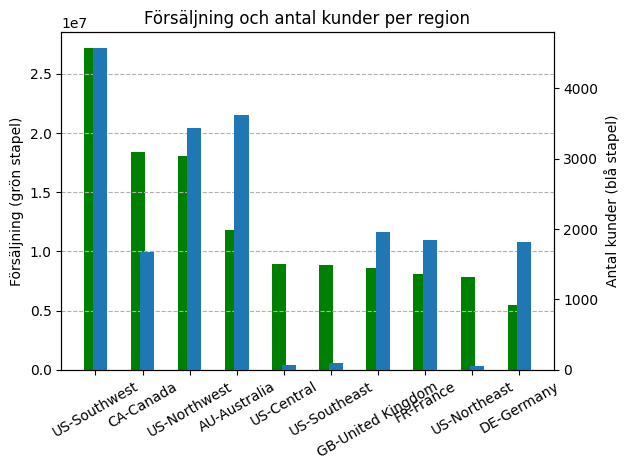

-----------------------------------------------
Högst försäljning: 27150595, region: US-Southwest
-----------------------------------------------
Lägst försäljning: 5479820, region: DE-Germany 
-----------------------------------------------
Flest unika kunder: 4565, region: US-Southwest
----------------------------------------
Minst unika kunder: 57, region: US-Northeast


In [20]:
q6 = """
SELECT CONCAT(sst.CountryRegionCode,'-', sst.Name) AS Region,
        SUM(ssoh.TotalDue) AS TotalFörsäljning,
        COUNT(DISTINCT sc.CustomerID) AS AntalKunder
FROM Sales.SalesOrderHeader ssoh
INNER JOIN Sales.Customer sc
    ON ssoh.CustomerID = sc.CustomerID
INNER JOIN Sales.SalesTerritory sst
    ON ssoh.TerritoryID = sst.TerritoryID
GROUP BY sst.CountryRegionCode, sst.Name
ORDER BY TotalFörsäljning DESC;"""
q6_df = query_df(q6)
# q6_df

x = np.arange(len(q6_df))
fig, ax = plt.subplots()
ax.bar(x - width/3, q6_df['TotalFörsäljning'], width=0.3, color='green')

ax2 = ax.twinx()
ax2.bar(x + width/3, q6_df['AntalKunder'], width=0.3)
ax.set_ylabel('Försäljning (grön stapel)')
ax2.set_ylabel('Antal kunder (blå stapel)')
ax.set_title('Försäljning och antal kunder per region')
ax.set_xticks(x, q6_df['Region'], rotation=30)
ax.grid(True, axis='y', linestyle='--')
plt.tight_layout()
plt.show()

# Winners & Losers..
max_sales = q6_df.loc[q6_df.TotalFörsäljning.idxmax()]
min_sales = q6_df.loc[q6_df.TotalFörsäljning.idxmin()]
max_customers = q6_df.loc[q6_df.AntalKunder.idxmax()]
min_customers = q6_df.loc[q6_df.AntalKunder.idxmin()]
print("-----------------------------------------------")
print(f"""Högst försäljning: {max_sales.TotalFörsäljning.round(0).astype(int)}, region: {max_sales.Region}""")
print("-----------------------------------------------")
print(f"""Lägst försäljning: {min_sales.TotalFörsäljning.round(0).astype(int)}, region: {min_sales.Region} """)
print("-----------------------------------------------")
print(f"""Flest unika kunder: {max_customers.AntalKunder.astype(int)}, region: {max_customers.Region}""")
print("----------------------------------------")
print(f"""Minst unika kunder: {min_customers.AntalKunder.astype(int)}, region: {min_customers.Region}""")

I grafen syns regioner och deras försäljning och antal unika kunder.

Insikter som fås är bland annat vilka kunder som gör flest orders eller driver mest intäkter framgår inte, fast grafen visar att Southwest i US driver in många ordrar och försäljning, medan till exempel Australien och US-Central driver mycket intäkter jämfört med antalet ordrar. Det sistnämnda föreslår att där finns mera stora kunder (företag) som lägger stora ordrar, förhållandevis. 

Bortsett från högst kunder och försäljning som tillföll US-Southwest är Tyskland där det säljs minst trots stora antalet kunder, som är tvärtom Australien och US-Central som alltså hade mycket intäkter på få kunder som troligtvis är privata konsumenter. 

## 3.7 Genomsnittligt ordervärde per region och kundtyp

Vilka regioner har högst/lägst genomsnittligt ordervärde och hur skiljer det sig mellan individuella kunder och företagskunder?

* *Metod:* 

Customers är 19820 rader, 18484 har personnummer och 1336 har butiknummer. INNER JOIN räcker för SalesOrderHeader, Customer och SalesTerritory tabellerna, samtidigt som LEFT JOIN på Customers behövs för vissa är företag och andra privatpersoner. Som i *3.6* konkateneras land och region. Division av summerade ordervärden med antal ordrar beräknar genomsnittligt ordervärde. CASE används i SELECT och GROUP BY för att få genomsnitten separata utefter sortens kund.

---------------------------------------------------
Högsta store ordersnitt: US-Southwest, 27739.1
Lägsta store ordersnitt : AU-Australia, 14415.8
---------------------------------------------------
Högsta individual ordersnitt: AU-Australia, 1490.4
Lägsta individual ordersnitt: US-Central, 368.4
---------------------------------------------------


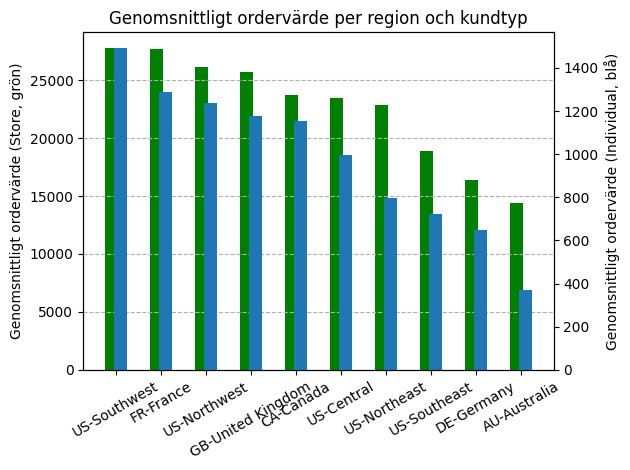

In [21]:
q7 = """
SELECT CONCAT(sst.CountryRegionCode,'-', sst.Name) AS Region,
    CASE
    WHEN sc.StoreID IS NULL THEN 'Individual' ELSE 'Store' END AS Kund,
    SUM(ssoh.TotalDue) / COUNT(ssoh.SalesOrderID) AS Snittvärde
FROM Sales.SalesOrderHeader ssoh
INNER JOIN Sales.Customer sc
    ON ssoh.CustomerID = sc.CustomerID
LEFT JOIN Sales.Store ss
    ON sc.StoreID = ss.BusinessEntityID
INNER JOIN Sales.SalesTerritory sst
    ON sc.TerritoryID = sst.TerritoryID
GROUP BY CONCAT(sst.CountryRegionCode,'-', sst.Name),
    CASE
    WHEN sc.StoreID IS NULL THEN 'Individual' ELSE 'Store' END
ORDER BY Snittvärde DESC;"""
q7_df = query_df(q7)
# q7_df.head(3)
# len(q7_df) # 20 lång

# Winners & Losers..
store_df = q7_df[q7_df['Kund'] == 'Store']
ind_df = q7_df[q7_df['Kund'] == 'Individual']
max_store = store_df.loc[store_df['Snittvärde'].idxmax()]
min_store = store_df.loc[store_df['Snittvärde'].idxmin()]
max_ind = ind_df.loc[ind_df['Snittvärde'].idxmax()]
min_ind = ind_df.loc[ind_df['Snittvärde'].idxmin()]
print("---------------------------------------------------")
print(f"Högsta store ordersnitt: {max_store.Region}, {max_store.Snittvärde.round(1)}")
print(f"Lägsta store ordersnitt : {min_store.Region}, {min_store.Snittvärde.round(1)}")
print("---------------------------------------------------")
print(f"Högsta individual ordersnitt: {max_ind.Region}, {max_ind.Snittvärde.round(1)}")
print(f"Lägsta individual ordersnitt: {min_ind.Region}, {min_ind.Snittvärde.round(1)}")
print("---------------------------------------------------")


#     Grupperad stapelgraf..
# Ta fram geografier sammansättandes privata- och företagskunder:
regiontotal_desc = q7_df.groupby('Region')['Snittvärde'].sum().sort_values(ascending=False)

x = np.arange(len(regiontotal_desc))
store = q7_df[q7_df['Kund'] == 'Store']['Snittvärde']
individual = q7_df[q7_df['Kund'] == 'Individual']['Snittvärde']

fig, ax = plt.subplots()

# Store på vänster y-axel
ax.bar(x - width/3, store, width, color='green', label='Store') # width är 0.3 från innan
ax.set_ylabel('Genomsnittligt ordervärde (Store, grön)')
ax.set_xticks(range(len(regiontotal_desc)))
ax.set_xticklabels(regiontotal_desc.index, rotation=30)
ax.grid(True, axis='y', linestyle='--')

ax2 = ax.twinx()
ax2.bar(x + width/3, individual, width, label='Individual')
ax2.set_ylabel('Genomsnittligt ordervärde (Individual, blå)')

plt.title('Genomsnittligt ordervärde per region och kundtyp')
plt.tight_layout()
plt.show()

Regionernas privata och företagskunder slogs ihop så fallande ordning på stapelgrafen blir rättvis (vilket erfodrade sättande av xticklabel), även en sekundär y-axel var välbehövlig. Grafen visar att företagen lägger större ordrar än individer, och med *3.6* analysen i förra delkapitlet syntes det att regioner hade mixad dynamik gällande antal kunder. Utan att granska sådan här data på flera perspektiv är det olika insikter som kan missas. 

I den numeriska specifikationen på högsta och lägsta regioner framgår skillnad mellan kundtyperna, medan kunder per region matchar grafen ovan gällande att Australien hade mycket intäkter jämfört med antal kunder. I Australien är företagen i framkant för intäkterna, så dessa synvinklar matchar varann. US-Northwest hade dock mycket kunder per region medan det inte sticker ut i denna grafen. Det går att lära sig mera, med flera perspektiv via uppdelningar, såsom mellan avvecklade produkter eller aktiva, och så vidare. 

Skillnader som förekommit i regional analys i *3.6* och *3.7* har ofta att göra med exempelvis om det är stora fjärrlager med försäljning för företag, eller om det är stora antal privatpersoner som handlar i befolkningstäta områden. 

## 3.8 Regional Försäljningsoptimering

### 3.8.1 Regioner över år

Hur många kunder och ordrar har regionerna över åren, samt hur såg försäljningen ut?

* *Metod:*

2025 och 2022 är halvår som ändå på tabell blir inräknade som egna hela år, vilket ger datan lite skew. Låt python fördubbla värdena på de åren gällande antal kunder, antal ordrar och totalförsäljning, så simuleras ett mer fullständigt dataset och även om inte eventuella säsongsmönster speglas korrekt av det fås ändå möjligtvis mer jämförbara grafer. 

Query ska ta fram antal ordrar och kunder med COUNT samt försäljning med SUM, gruppera efter område och årtal med stigande ordning. Eftersom det är 4 år och 10 områden fås 40 rader som dataframe output. Utefter detta görs grupperade stapelgrafer med hjälp av Python's .pivot() på ordrar, försäljning och kunder för översikt på prestationer efter område (alfabetisk och kronologisk sortering för region och år, respektivt). Eftersom antal kunder och ordrar beror på varandra sätts de visualiseringarna vid sidan av varann, då vi tidigare har sett att ordrar och försäljning inte helt rörde sig i tandem. Alla tre graferna får inte så bra plats intill varann, så först visas försäljning:

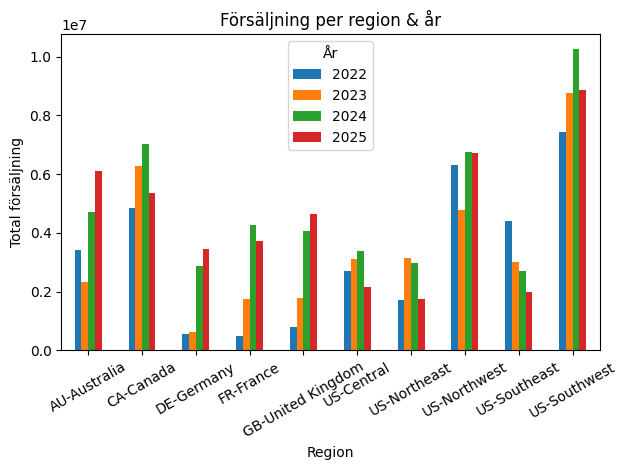

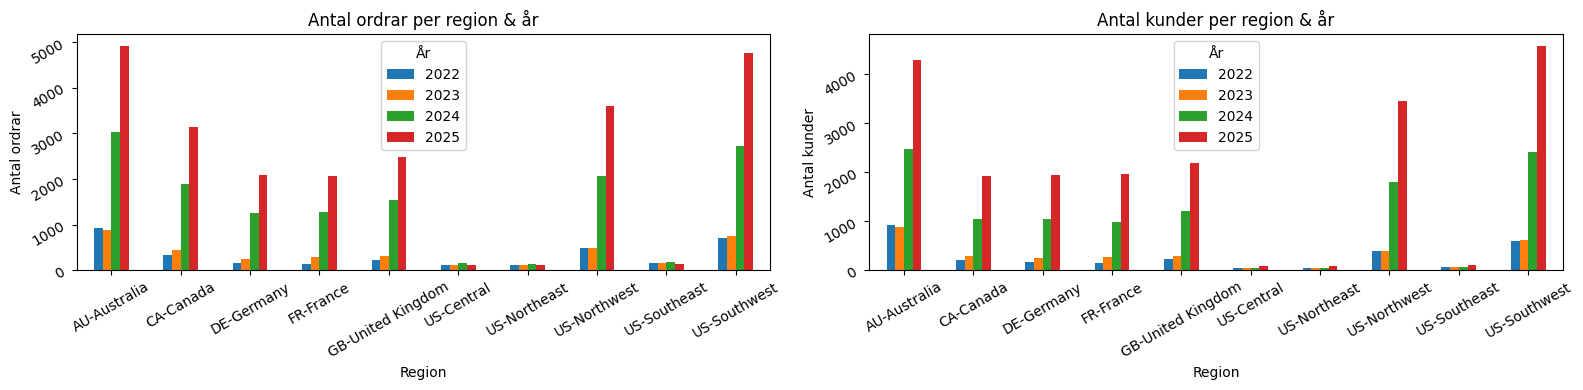

In [22]:
q8_1 = """
SELECT CONCAT(sst.CountryRegionCode, '-', sst.Name) AS Region,
    YEAR(ssoh.OrderDate) AS År,
    SUM(ssoh.TotalDue) AS TotalFörsäljning,
    COUNT(DISTINCT sc.CustomerID) AS AntalKunder,
    COUNT(ssoh.SalesOrderID) AS AntalOrdrar
FROM Sales.SalesOrderHeader ssoh
INNER JOIN Sales.Customer sc
    ON ssoh.CustomerID = sc.CustomerID
INNER JOIN Sales.SalesTerritory sst
    ON ssoh.TerritoryID = sst.TerritoryID
GROUP BY sst.CountryRegionCode,
    sst.Name,
    YEAR(ssoh.OrderDate)
ORDER BY Region, År;"""
q8_1_df = query_df(q8_1)
# q8_1_df.head(5) # 40 lång

# Dubblera första och sista årets siffror
mask = q8_1_df.År.isin([2022, 2025])
q8_1_df.loc[mask, ['TotalFörsäljning', 'AntalKunder', 'AntalOrdrar']] *= 2
q8_1_df.head()

# Omgruppera så årtal hamnar som kolumner
pivot_sales = q8_1_df.pivot(index='Region', columns='År', values='TotalFörsäljning')
pivot_sales.plot(kind='bar') # automatisk grupp hantering

plt.title('Försäljning per region & år')
plt.xlabel('Region')
plt.ylabel('Total försäljning')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

# Nu visar vi ordrar och kunder:
pivot_orders = q8_1_df.pivot(index='Region', columns='År', values='AntalOrdrar')
pivot_customers = q8_1_df.pivot(index='Region', columns='År', values='AntalKunder')

fig, ax = plt.subplots(1, 2, figsize=(16,4))
pivot_orders.plot(kind='bar', ax=ax[0])
ax[0].set_title('Antal ordrar per region & år')
ax[0].set_xlabel('Region')
ax[0].set_ylabel('Antal ordrar')
ax[0].tick_params(rotation=30)

pivot_customers.plot(kind='bar', ax=ax[1])
ax[1].set_title('Antal kunder per region & år')
ax[1].set_xlabel('Region')
ax[1].set_ylabel('Antal kunder')
ax[1].tick_params(rotation=30)
plt.tight_layout()

Försäljningen syns stigande för Australien, Tyskland, Frankrike, UK, och southwest US vid inspektion av riktningen från vänster till höger, per region. Southeast US har en negativ intäkt-trend. Kanada, Northwest och Southwest US har konsistent hög försäljning även om antalet kunder och ordrar ökar för de regionerna, något som tyder på att intäkterna är ungefär densamma men ett skifte från företagskunder till privatkunder verkar ligga bakom.

För alla områden, förutom centrala, nordöstra och sydöstra US, stiger ordrar och kunder med åren. För kanada är dock försäljningen lite stigande, sedan lite dalande

Ökningar i procent och genomsnitt av detta tas inte fram för dels är årtalen inte fullständiga och delvis simulerade (för första och sista året), och det viktiga med att börja med denna översiktliga analys per region är för att kunna spåna vidare på regional optimering, besvarandes varför vissa platser är mer i försäljningens centrum. Det går även att få insikter i effektivitet och volym, som tidigare skådat med kundtypsanalysen går därmed att gissa vilka områden som är business to business (*B2B*) eller retail försäljning.

### 3.8.2 Produktkategori per region

Vilka produktkategorier säljer bäst var?

* *Metod:*

Här tas alla år sammanslagna i datan, detta gör visualisering i form av värmekarta mer precis och vi behöver inte simulera data för att fullända 2022 och 2025 som innan. Dessutom inräknas inte okategoriserade produkter, som ändå inte har sålts. Denna analys visar därmed inte säsongsmönster, nämligen ger den kategoripreferenser per region. Python's .pivot() görs enklare ovanpå query resultat, än att göra ett pivottable via query, och seaborn används för heatmap som är i alfabetisk ordning för regionerna.

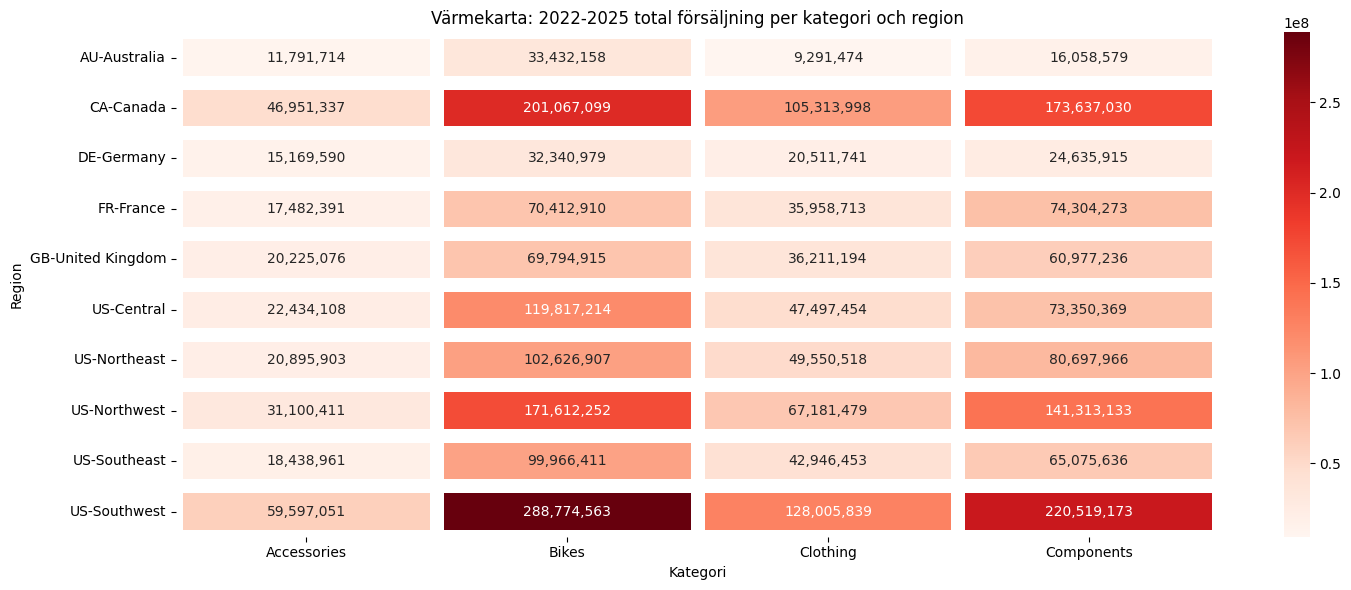

In [23]:
q8_2 = """
SELECT CONCAT(sst.CountryRegionCode,'-',sst.Name) AS Region,
    ppc.Name AS Kategori,
    SUM(ssoh.TotalDue) AS TotalFörsäljning
FROM Sales.SalesOrderHeader AS ssoh
INNER JOIN Sales.Customer AS sc
    ON ssoh.CustomerID = sc.CustomerID
INNER JOIN Sales.SalesTerritory AS sst
    ON sc.TerritoryID = sst.TerritoryID
INNER JOIN Sales.SalesOrderDetail AS ssod
    ON ssoh.SalesOrderID = ssod.SalesOrderID
INNER JOIN Production.Product AS pp
    ON ssod.ProductID = pp.ProductID
INNER JOIN Production.ProductSubcategory AS pps
    ON pp.ProductSubcategoryID = pps.ProductSubcategoryID
INNER JOIN Production.ProductCategory AS ppc
    ON pps.ProductCategoryID = ppc.ProductCategoryID
GROUP BY 
    CONCAT(sst.CountryRegionCode,'-',sst.Name),
    ppc.Name
ORDER BY Region, TotalFörsäljning DESC;"""
q8_2_df = query_df(q8_2)
q8_2_df.head() # 40 lång

pivot_sales = q8_2_df.pivot(index='Region', columns='Kategori', values='TotalFörsäljning')


import seaborn as sns
plt.figure(figsize=(15, 6))
sns.heatmap(pivot_sales, cmap='Reds', annot=True, fmt=',.0f', linewidths=10)

plt.title('Värmekarta: 2022-2025 total försäljning per kategori och region')
plt.xlabel('Kategori')
plt.ylabel('Region')
plt.tight_layout()

Grafen visar ledande kategorier per region. Cyklar är framstående i värmekartan, även komponenter, vilket speglar tidigare kategorianalys i *3.2* att cyklar säljer mest och komponenter näst mest, medan ovan värmekarta också visar att cykeldelar säljs många av, där cyklar säljs. Specifikt är Southwest US och Kanada de framstående regionerna, följt av Northwest US. 

Värmekartans kategorier har relativa siffror så att andra kategorier inte blir dämpade i. Det återstår att se hur regionerna presterar över tid, och även skulle det gå att filtrera fram endast aktiva produkter, vilket skulle påverka siffrorna i värmekartan (som ej gås in i detalj på).

### 3.8.3 Säsongsmönster per region

Finns säsongsmönster per region?

* *Metod:*

Query ger år och månad separata, som python kan lägga till en datetime kolumn förmånligt för plotting. En linjegraf med 10 kurvor delas istället upp på två subplots, så fås försäljningen per region per månad. Visualiseringen visar försäljningsmönstret, vilket förväntas ha lite ihållande ökande och sen kvickt fallande mot slutet av tidsperioden, kommandes ihåg att försäljning inte var helt följaktigt efter antalet ordrar som i *3.4*. Pivottabeller kan fånga årets 12 månader och addera månadernas försäljning, varav första och sista året har inte fullständiga siffror då där fanns halvår med data. Ändå går det att ta fram bäst presterande månaderna med pivottabell särskilt genom normalisering över hur många gånger månaderna förekommit, och som i *3.3*, går det att göra linjegrafer med till exempel utvalda regioners prestationer just för varje Januari. Detta är aktuellt då det är svårt att titta på en månad, sedan hoppa över 12 månader och försöka jämföra med nästa års samma månad. Då det är 10 regioner föredras Python's for loop vid grafritandet.

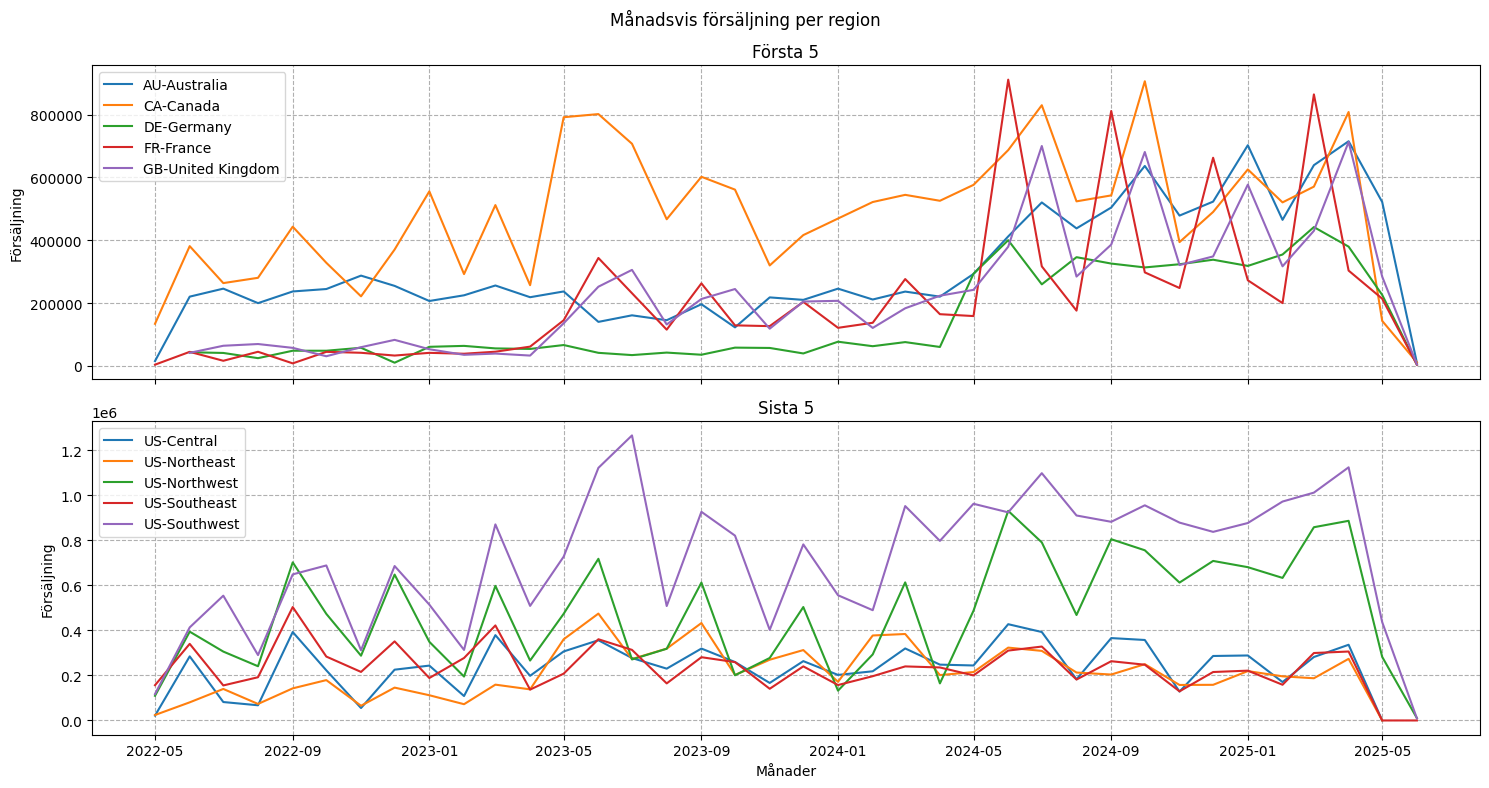

In [24]:
q8_3 = """
SELECT CONCAT(sst.CountryRegionCode, '-', sst.Name) AS Region,
    YEAR(ssoh.OrderDate) AS År,
    MONTH(ssoh.OrderDate) AS Månad,
    SUM(ssoh.TotalDue) AS TotalFörsäljning,
    COUNT(ssoh.SalesOrderID) AS AntalOrdrar,
    COUNT(DISTINCT sc.CustomerID) AS AntalKunder
FROM Sales.SalesOrderHeader AS ssoh
INNER JOIN Sales.Customer AS sc
    ON ssoh.CustomerID = sc.CustomerID
INNER JOIN Sales.SalesTerritory AS sst
    ON sc.TerritoryID = sst.TerritoryID
GROUP BY 
    sst.CountryRegionCode,
    sst.Name,
    YEAR(ssoh.OrderDate),
    MONTH(ssoh.OrderDate)
ORDER BY Region, År, Månad;"""
q8_3_df = query_df(q8_3)

# för att plussa ihop år och månader görs det med string.
datestring = q8_3_df.År.astype(str)+'-'+q8_3_df.Månad.astype(str)+'-01'
q8_3_df['Datum'] = pd.to_datetime(datestring)
# q8_3_df.head(10) # 376 rader

region = q8_3_df['Region'].unique()
five_1, five_2= region[:5], region[5:] # första & sista fem (alfabetiskt)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

for region in five_1:
    temp_df = q8_3_df[q8_3_df.Region == region]
    ax1.plot(temp_df.Datum, temp_df.TotalFörsäljning, label=region)

for region in five_2:
    temp_df = q8_3_df[q8_3_df.Region == region]
    ax2.plot(temp_df.Datum, temp_df.TotalFörsäljning, label=region)

ax1.set_title('Första 5'), ax2.set_title('Sista 5')
ax1.set_ylabel('Försäljning'), ax2.set_ylabel('Försäljning')
ax2.set_xlabel('Månader')
ax1.grid(True, linestyle='--'), ax2.grid(True, linestyle='--')
ax1.legend(), ax2.legend()
plt.suptitle('Månadsvis försäljning per region')
plt.tight_layout()

I helhet fluktuerar försäljningarna likartat, medan till exempel Tyskland och Australien inte är volatila förrän lite mer än halvvägs igenom. Kanada och Southwest US är bland de med högst inkomster, vilket matchar resultaten i *3.6*.

Gällande linjerna som avspeglar intäkterna, 3 av dem hade ingen försäljning sista hela månaden och alla regioner sålde inget vid slutet, vilket kan tolkas som att sista månaden har inte börjat och fortsättning skulle avvisa den visade trenden med mycket låg försäljning som avslut vilket ändå motsägs då försäljningen saktar in mot slutet, inte bara går direkt till 0. Det valdes inte att dubblera siffrorna för första och sista helåren, vilket inte behövs för grafen ovan och linjegrafen i *3.3* som båda handlar om försäljning per månad och båda beaktar inte simulerade värden och är därför jämförbara med varann.

Hur data kapas, eller *trunkeras*, kan framhäva programmeringsrelaterade bieffekter. Början av tidsperioden hade flera regioner viss försäljning men ändå låg, så det verkar vara hur datasetet är designat med uppgång och nedgång. Återkommande är att sammanhanget av data är betydande för affärsfrågor, så när prognoser ska göras medföljer ofta antaganden eller *caveats* som till fördel för analysen bör bemötas. Detta diskuteras mer i *4. Reflektion*. 

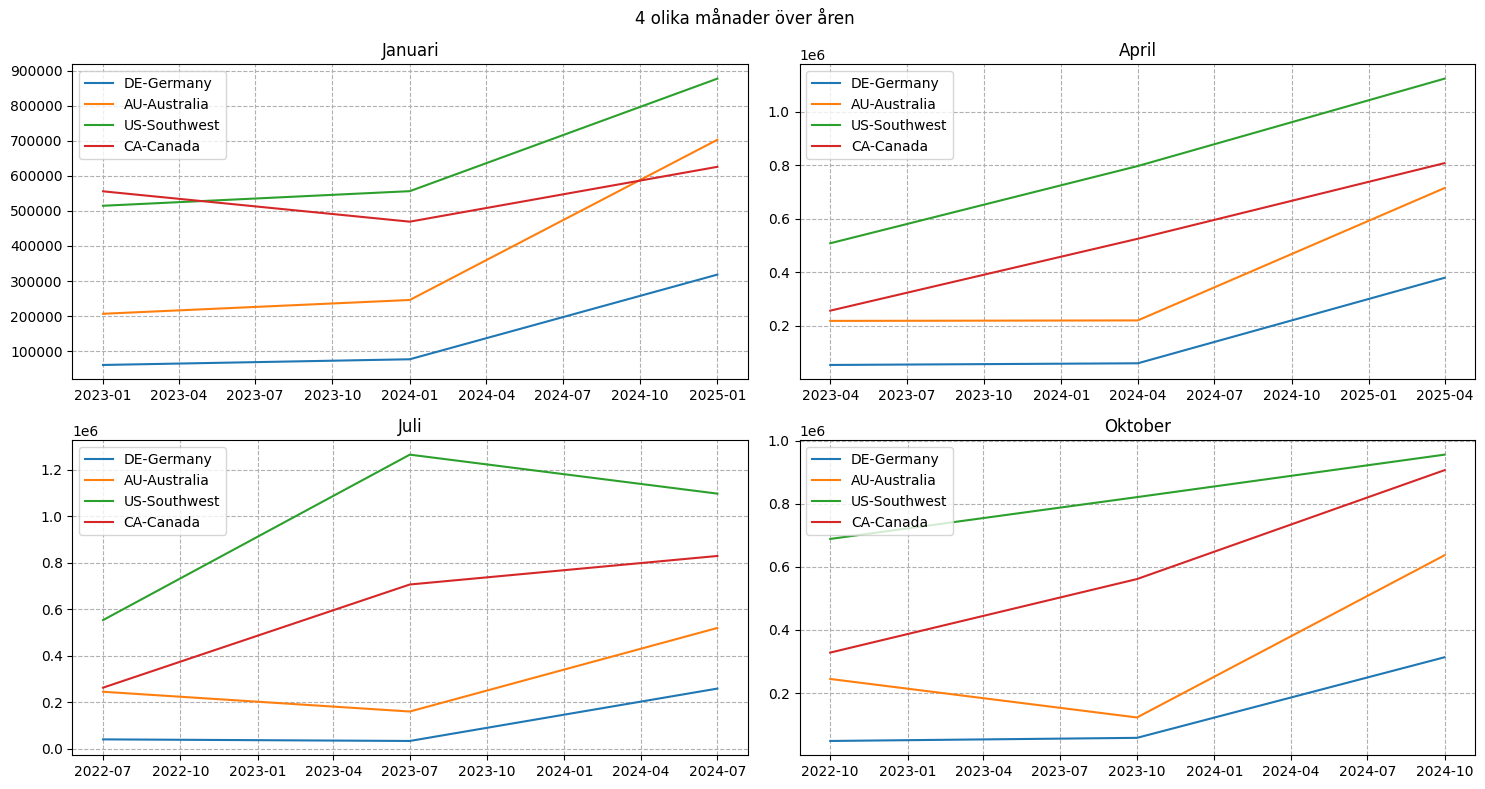

Högst försäljning: månad 3, med 12,748,069.
-------------------------------------------
Lägst försäljning: månad 11, med 7,372,049.


In [25]:
months_choice = [1, 4, 7, 10]
month_name = {1: "Januari", 4: "April", 7: "Juli", 10: "Oktober"}
regions_choice = ["DE-Germany", "AU-Australia", "US-Southwest", "CA-Canada"]

fig, axes = plt.subplots(2, 2, figsize=(15, 8))

axes = axes.flatten() # för att kunna loopa över axlarna som en platt array.
for ax, month in zip(axes, months_choice): # .zip() sätter ihop axel med månad
    temp = q8_3_df[(q8_3_df.Månad == month) & (q8_3_df.Region.isin(regions_choice))]

    for region in regions_choice:
        region_df = temp[temp.Region == region]
        ax.plot(region_df.Datum, region_df['TotalFörsäljning'], label=region)

    ax.set_title(f'{month_name[month]}')
    ax.grid(True, linestyle='--')
    ax.legend()

plt.suptitle('4 olika månader över åren')
plt.tight_layout()
plt.show()

# Winners & losers..
month_totals = q8_3_df.groupby('Månad')['TotalFörsäljning'].sum()
max_month, min_month = month_totals.idxmax(), month_totals.idxmin()
max_value, min_value = month_totals.max(), month_totals.min()
print(f"Högst försäljning: månad {max_month}, med {max_value:,.0f}.")
print('-------------------------------------------')
print(f"Lägst försäljning: månad {min_month}, med {min_value:,.0f}.")

Grafen ovan visar att intäkter har stigit eller stannat samma för januari och tredje nästa månad, och så vidare. Från första juli till juli, där linjen bara går rakt från första till andra värdet och mellanvarande månader inte spelar roll, hade Southwest US stor ökning i intäkter, och vetandes att total försäljning ökade från start och slutade med en dipp syns den allmäna trenden i grafen, varvid om linjerna vore rakt horisontella vid förhöjda värden på vissa månader och andra inte, vore det tecken på säsongalitet.

## 4. Reflektion

Jag valde att dyka ner i regional försäljningsoptimering för det skulle komplettera mycket av de första sju delkapitlen i *3. Visualiseringar* och framhäva djupare nyanser. Det åsido är ändå kostnadsstrukturen i jämförelse med intäkter intressant inom produktportfölj-analys eftersom många mätvärden ges från det; vinstmarginaler och liknande. Kundvärde-analys om lifetime värden eller beteenden är också en intressant fallvinkel som visar bl.a. toppkunderna och det ger utrymme för att göra affärsrekommendationer. Sådana tips kan även göras med produktportfölj- eller regional försäljningsanalys också. I det sistnämnda ville jag se försäljning per region för alla 10 områden, för det knyter an till alla tidigare visualiseringar.

Det var förmånligt att aggregera i SQL för då får man en dataframe som går snabbt för python att visualisera, och med några rader python-kod kan queryns output omarbetas för omklassificerade mätvärden eller visualiseringar, alltså skina nya ljus på datan från olika perspektiv. Omaggregering i python från att ha alla månaders försäljning från query går enkelt till aggregering på års-nivå, till exempel. Meningen är att hämtar man tillräckligt med data går det att borra ner i olika nivåer, men hämtas bara småskalig data går det inte att göra storskaliga utlåtanden. Det är ett naturligt arbetsflöde att inte hämta allt, bättre att vara lite restriktiv och hämta allt som behövs och gör initiell beräkning så att python kan ta det vidare. 

För *3.8.1* t.o.m. *3.8.3* gjordes grupperat stapeldiagram, heatmap och linjediagram varav bara heatmapen räknade på totalförsäljning över hela tidsperioden, och de andra, gruppstapel- och linjediagramen gick över helår och månader, respektivt. Från heatmapen framgick att cyklar och komponenter säljs mest och detta i Kanada och Southwest- och Northwest US. Det visades i grupperat stapeldiagram hur antal kunder och ordrar ändras över åren jämfört med försäljningen, vilket gjorde det möjligt att se vart företagskunder eller privatkunder driver mest intäkter och hur intäkter stannade densamma ungefär i Southwest US medan antalet kunder och ordrar ökade med multiplar så där ökar privatkunder. Och att få se olika regioner som egna kurvor på två samlade linjegrafer gjorde det enkelt att se vart försäljningen är volatil eller regelbunden. Alla visualiseringar täcker olika fallvinklar på samma data, så analys på dem kan ge stöd för strategiska affärsråd som säkert företagets förvaltare är intresserade av att höra.

I *3.8.1* och *3.8.2* användes python's pivot table på en query som undgick att bli aggregerat på ett specifikt sätt, det räckte att ge mätvärden över årtal grupperat efter region (som inte behövs vara sorterad efter region alfabetiskt) men mera viktigt att datan via query hamnar som kolumner, och i grafritning är ofta *wide format* att föredra, för då kan en region vara en rad med årtal som x-axel och försäljning som värde. Datan läses snabbare eller är enklare, att ha horisontell data för pythons grafritning. Därför får pivot tables göras efter SQL query.

Utmaningar stöttes på från start till slut av projektet de sammanfattas nedan:
* *3.1 - Ordrar per kategori* 
    * Förekommer okategoriserade produkter.
    * *Åtgärd:* Visa okategoriserade produkter, rapportera inte okategoriserade produkter som ledande bara för att dem var flest. 
* *3.2 - Försäljning per kategori*
    * Skall det räknas med produkter som slutat säljas?
    * *Åtgärd:* Visa försäljning för aktiva produkter och även aktiva plus avvecklade produkter, och jämför resultaten.
* *3.3 - Försäljning per månad*
    * Otydliga trender.
    * *Åtgärd:* Förklara implikationerna och gör observationer och försök till upptäckt av säsongsmönster ändå. Det gjordes samma mönsterundersökning i slutet av *3.8.3* per region som tillägg och grafen matchar *3.3* i utseende.
* *3.4 - Försäljning och ordrar per år*
    * Halvtomma finansår 2022 och 2025.
    * *Åtgärd:* Gjorde anpassade år där start räknas som månad 1 och visade hur det förändrade linjegrafernas rörelse (utkommenterad graf vs. *Justerat finansiellt år*), dock blev 2025 ett kort och ofullständigt år, medan första året blev ett helt. 
* *3.5 - Top 10 produkter*
    * Storlek och färg trasslar till gruppering, & ska bara aktiva produkter beräknas?
    * *Åtgärd:* Använd CASE i query för att få mer sofistikerade aggregeringar, vilket endast genomfördes för storlek då stringmanipulationen klippte av allt efter kommatecken. Hur produkter benämns avgör hur queryn behöver vara utformad.
* *3.6 - Försäljning och kunder per region*
    * Gruppering av region kan beblandas vid internationell data, & företag vs. kunder har olika försäljningstrender.
    * *Åtgärd:* Håll land och region som unika kombinationer i query, och utläs om regioner har ökande antal kunder eller ordrar kontra försäljning.
* *3.7 - Genomsnittligt ordervärde per region och kundtyp*
    * Måste aggregera korrekt på ordernivå vs. orderradnivå, & företag vs. kunder har olika försäljningstrender.
    * *Åtgärd:* Var noggrann med visualiseringen, knyt an till vetskap från andra delkapitel gällande trender.
* *3.8.1 - Regioner över år*
    * Ordrar och kunder ökar med blandade försäljningstrender, även halvtomma finansår som problematik.
    * *Åtgärd:* Dubblerade första och sista årens värden som simulering och visa vart olika trender skiljer sig.
* *3.8.2 - Kategori per region*
    * Icke tidsanpassad analys, men relativitet i värmekartans färgintensiteter visar framstående produkter, varav tidigare delkapitel behövdes ofta två y-axlar för skillnader i magnituder.
    * *Åtgärd:* Visade att försäljning per kategori över olika regioner håller mönstret att cyklar och komponenter säljer mycket med närvaro av samband för de kategorierna.
* *3.8.3 - Försäljning per region över tid*
    * Blandade trender och datasetets konstruktion eller trunkering är problematiskt med så kort total tidsperiod i datasetet.
    * *Åtgärd:* Kommentera på hur regionernas försäljning rör sig och hur försäljning för varje Januari, April, Juli & Oktober för att komplettera motsvarande i *3.3*.
    
I sin helhet är det många krux, eller *caveats*, som behövs bemötas eller tas med som sammanhang för presenterad data. Sådan här analys är bra att göra innan det görs förhållande mätvärden, såsom att säga att försäljning ökat med 50% kan vara värdefullt för kvantitativa metoder medan data blir mer överskådlig med visualiseringar och att få förklarande sammanband klargjorda. Procentuella jämförelser är således en väg för vidare studier från denna punkt.

**Rekommendationer:**
* I *3.8.1* visades ökande kunder och orderantal för alla regioner utom US Central och US Northeast vars kunder må vara företag, medan US Southwest, US Northwest och Kanada har haft störst intäkter. För dessa tre högpresterande regioner som haft ökande kunder och ordrar är det inte utrett hur fortsättningen behöver se ut för fortsatta ökade intäkter. Utmaningar kan vara att konkurrenter kan prisunderskära för att ta över marknadsandelar, så att behålla vinstmarginaler och kundbaser är viktigt med ökande kundbas när marginaler pressas och exempelvis när leverantörernas priser för varor ökar. Där kunder och ordrar inte ökade går det att råda om ökad marknadsföring, om de regionerna inte är lättåtkomliga eller om det är business to business försäljning där är detta råd inte helt tillämpbart, idén är dock att om det är höga ordervärden där så är det bra att öka antalet ordrar inkomna. Det kan göras lönsamma affärer där det finns välbemedlade kunder. Analys av lönsamhet och kostnadsstruktur ger mera utrymme för regionala rekommendationer. Med längre historisk data skulle det gå att bedöma hur intäkter skalar med ökande kunder, såsom i Tyskland som haft ökade intäkter och kunder. Erbjudande av rabatter och andra strategier i företaget kan ge skiftande kundtrender, fast närvaron av blandade mönster mellan de olika regionerna kan försvara att takiker borde få variera efter område och beteenden, såsom att vissa lokaler kan vara mer tillgängliga för bilister och andra passar fottrafikanter och det som handlas av kunderna kan skilja sig av bara det.
    * *Rekommendation:* Höginkomst-regioner med ökande kunder och ordrar bör se till bibehållen vinstmarginal om uppskalning fortsätter, och av kunder lågtrafikerade regioner borde satsningar göras på att skala upp kundantal och ordrar mer än att sikta på högre vinster från samma kundbas, vilket skulle kunna försvaga kundrelationer.

* I *3.8.2* visades värmekarta på produktkategoriernas totala försäljning inräknandes alla år per region, där högstpresterande områden leder försäljningen med cyklar och komponenter, samtidigt som jämnare fördelade kategorier såsom Tyskland också fanns. Butiker med brett utbud av cyklar kan ha goda omdömen som lockar flera kunder, eller så är de områden där cyklar används mycket och att butiken snappar upp många kunder. Råd görs här inte i optimering för tidsdimensionen räknades ihopsatt, så indikationer av regionala styrkor är vad som går att råda i.
    * *Rekommendation:* Fortsätt med att förse kunder med cyklar och komponenter på de flesta platser, med mera balanserad fokus mellan kategorier i Tyskland, som inte hade så cykeldrivna intäkter. Fortsätt också med att ha försyn på åtgång och tillgång av cyklar och komponenter i populära regioner, vilket går att få stöd i från analys av orderflöden. Det råds inte att avveckla någon kategori för någon region då sådant kan ha kundrelations-implikationer, och då denna analys inte är tillräcklig för det, snarare är vidare analys viktig för Tyskland och Australien, som hade minst mönster av att cyklar och komponenter säljs mest.

* I *3.8.3* syntes liknande trender i försäljning per månad per region, fast vissa hade toppar och dalar ända från start till slut när några få som Tyskland och Australien hade regelbundna nivåer första två tredjedelarna av tidsperioden. Hur stabil tillväxten är, och om den kommer från en förtänkt satsning på sortiment som cyklar och senare uppföljande marknadsföring och försäljning, eller om det råder hög efterfrågan som längsmed tid företaget försöker nå ikapp med bristfälliga mängder cyklar i butiker är indikationer som kan stå ut från att kolla försäljning i *3.8.3* och ordrar \& kunder i *3.8.1*. Säsongsmönster såsom högtider kan vara en bidragande faktor till volatilitet i försäljning, fast då styrka och timing varierade medan försäljning allmänt ökade var det svårt att verifiera utifrån visualiseringar, mätvärden på förändringar och jämförelser mellan regioner skulle kompletterat utrymmet att bedöma säsongsbundenhet och att ge rekommendationer. Att nu det var kort orderhistorik samt att försäljningen började lågt för att sedan ha en väl talande graf som sedan gick till noll igen för alla regioner sista månaderna ändrar inte råden.
    * *Rekommendation:* Strategier för lagersaldo och försäljning av främst cyklar och komponenter borde matcha existerande volatila regioner, och vidare analys av produktkategoriers försäljning per region över tid, och helst på längre försäljningsdata, behövs för att ge underlag till strategierna. Tyskland och Australien behövde inte satsa specifikt på cyklar och komponenter för de första åren eftersom kategorier sålde jämnare där.

## 5. Sammanfattning

**För delkapitlen *3.1* till och med *3.7* togs upp:**
* Det finns flera produkter inom komponenter än cyklar, och kläder samt accessoarer är många färre än de första två. Cyklar säljer för mera givet högre pris, och kunderna köper då ofta komponenter i sammanhanget, eller vart fall borde butiken försöka sälja både och vid varje kundbesök. 
* Trenden för försäljningsnivåerna är mestadels positivt lutad vilket gjorde säsongsbundenhet svårt att bedöma, något numeriska jämförelser skulle kunna stötta.
* Aktiva produktutbudet gjorde synligt att avvecklade produkter är del av historisk försäljning medan att fokusera på aktiva produkter visar pågående marknad, vilken borde optimeras mot efterfrågan. Om en populär produkt skulle sluta säljas p.g.a leverantör minskar intäkter, så ersättande med likvärdig produkt behövs.
* Intäkter för företaget i helhet har haft stadig uptrend, medan säsongsbundenhet var blandad.
* Att ha halvår's data som start och slut på datasetet gör aggregering riskabelt för felprognotiseringar. 
* Att månatliga ordrar inte alltid måste vara drivande för försäljning, dock var detta inte regionalt uppdelat i visualiseringen *Månadsvis försäljning + ordrar*.
* Att querys i SQL med gruppering av produkter behöver entydig struktur vid användande av stringfunktioner, nämligen var produkternas färg och storlek skiljaktiga.
* Att US Central och US Southeast hade lågt antal kunder men medelhöga intäkter. Andra platser hade mera kunder uppgörandes försäljningen.
* Att företag och privatpersoner lägger olika stora ordrar.
* Att orsakssamband inte kan bestämmas för externa variabler utan att behöva byta forskningsspår och göra grundlig utvärdering om exempelvis kostnadsstruktur eller kundvärdesanalys.
* Att skriftliga observeringar av grafer tar mycket utrymme och upprepande över olika sammanhang, så grundliga analyser måste hållas inom ramarna för affärsfrågorna.

**Rekommendationer från *3.1* till *3.7*:**
* Både cyklar och komponenter, som står för stor del av intäkterna, ska företaget vara aktsamma med gällande tillsyn att lager kommer räcka till efterfrågan som kan vara säsongsbunden, och så ska företaget hålla produktutbudet uppdaterat.
* Cykelpopulära butiker borde försöka sälja cyklar och komponenter till kunder via rabatter eller liknande.
* Regioner med färre kunder ska fortsätta satsa på *business to business* försäljning medan kundtätare regioner ska anpassa butiker efter privatpersoner.

**Sammanfattning:**

Med initiella datahämtningar anpassade till att ge lagom bredd och tillräckligt djup för en affärsfråga följs detta upp med omarbeten av datahämtningen, där grafer, specificerade högsta och lägsta mätvärden och validering av data i samband med upptäckt av rådande *caveats*. Analys började med försäljning hos produkter, intertemporärt, kundtyper och regioner och handlade sedan om regional optimering. I mixen av ökande försäljning och blandade mönster som kan bero på taktiska anpassningar i aktivt produktutbud till efterfråga och plats så borde detta bibehållas och vidare analys för produktkategorier som säljs jämnt skulle vara fördelaktigt. Problematiskt var trunkerad data och att bara halvårs data fanns i första och sista året, så icke-anpassad utformad data kan leda till grupperingsmisstag och missvisande resultat, skulle de tolkas som hela. Andra forskningsområden än regional optimering är kundvärdesanalys och kostnadsstruktur, för att inte nämna logistik.